In [1]:
results_file = "earlystop_centered_priors"

In [2]:
import plotly.io as pio

interactive_plots = False
if interactive_plots is False:
    pio.renderers.default = "svg"
else:
    pio.renderers.default = "plotly_mimetype+notebook"
    
red = "#E07182"
blue = "#4487D3"
green = "#96D6B4"
purple = "#B140C8"
grey = "#87878A"

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from pytorch_tabnet.tab_model import TabNetRegressor

import torch
import pyro
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_value

from tqdm.notebook import tqdm
from copy import deepcopy

import sys
sys.path.append("../src")
from preprocessing_utils import get_categs_mappings, get_emb_size
from bnn_utils import as_pyro_module, get_predictions_pyro
from metrics import get_empiric_coverage_curve, get_metrics, compute_confidence_intervals
from plots import plot_metrics, plot_coverage_curves, plot_lines, plot_areas, add_title_and_axis

**features** and **target** definition

In [4]:
numerical_features = ['bmi', 'age']
categorical_features = ['sex', 'smoker', 'children', 'region']
features = categorical_features+numerical_features
target = 'charges'

# Load Data
- load data
- partition data
- transform target: scaled down using quantile 95%

In [5]:
data_path = '../data/insurance.csv'

data = pd.read_csv(data_path)#.drop(['Unnamed: 0'], axis=1)

non_train_index = data.sample(frac=.2, random_state=1312).index
np.random.seed(1312)
test_index = np.random.choice(
    non_train_index, size=len(non_train_index)//2, replace=False
)
valid_index = [i for i in non_train_index if not i in test_index]

data['partition'] = "train"
data.loc[test_index, 'partition'] = "test"
data.loc[valid_index, 'partition'] = "valid"

q95 = data.query('partition == "train"')[target].quantile(.95)

def transform(x):
    return x/q95

def inv_transf(x):
    return q95*x

data[target+'_transf'] = transform(data[target])
data.loc[:, categorical_features] = data.loc[:, categorical_features].astype('category').copy()

<AxesSubplot:>

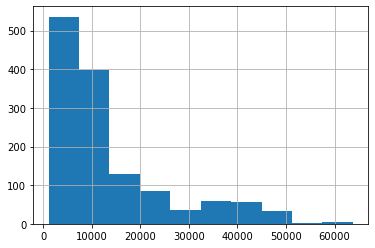

In [6]:
data[target].hist()

In [7]:
data.partition.value_counts(normalize=True)

train    0.799701
valid    0.100149
test     0.100149
Name: partition, dtype: float64

# Preprocessing
feature transformation preprocessor

In [8]:
categs_mappings = get_categs_mappings(data.query("partition == 'train'"), categorical_features)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', fill_value=np.NaN)), 
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="N/A")),
    ('label', OrdinalEncoder(handle_unknown="value", mapping=categs_mappings)), #uknown values goes to -1
    ('imputer_uknow', SimpleImputer(missing_values=-1, strategy='constant', fill_value=0)), #uknown values go to 0, the index for NaN
    ])

preprocessor = ColumnTransformer(#preprocessor rearenge columns
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)]
)


preprocessor.fit(data.query("partition == 'train'")[features])

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('label',
                                                  OrdinalEncoder(mapping=[{'col': 0,
                                                                           'mapping': {'N/A': 0,
                                                                                       'female': 1,
                                                                                       'male': 2}},
                                                                          {'col': 1,
                                                                           'mapping': {'N/A': 0,
                                                                                       'no': 1,
           

# Define categorical embeddings

In [9]:
cat_dims = [data.query("partition == 'train'")[feature].nunique()+1 for i, feature in enumerate(categorical_features)]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_features]
cat_emb_dim = [get_emb_size(n_cat) for n_cat in cat_dims]
cat_emb_dim

[3, 3, 5, 4]

# Deterministic Model

## Model training

In [10]:
X_train = preprocessor.transform(data.query("partition == 'train'")[features])
y_train = (data.query("partition == 'train'")[target+'_transf']).values.reshape((-1, 1))

X_test = preprocessor.transform(data.query("partition == 'test'")[features])
y_test = (data.query("partition == 'test'")[target+'_transf']).values.reshape((-1, 1))

In [11]:
regressor = TabNetRegressor(
    cat_dims=cat_dims, 
    cat_emb_dim=cat_emb_dim, 
    cat_idxs=cat_idxs,
    seed=1312
)

Device used : cuda


In [12]:
max_epochs = 100
regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=128,
    num_workers=0,
    drop_last=False,
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', regressor)])

epoch 0  | loss: 0.12698 | train_mae: 0.26663 | test_mae: 0.31672 |  0:00:00s
epoch 1  | loss: 0.05403 | train_mae: 0.21237 | test_mae: 0.24971 |  0:00:01s
epoch 2  | loss: 0.04454 | train_mae: 0.19786 | test_mae: 0.22465 |  0:00:01s
epoch 3  | loss: 0.03932 | train_mae: 0.1894  | test_mae: 0.21143 |  0:00:01s
epoch 4  | loss: 0.03308 | train_mae: 0.16598 | test_mae: 0.17917 |  0:00:02s
epoch 5  | loss: 0.03219 | train_mae: 0.14682 | test_mae: 0.16315 |  0:00:02s
epoch 6  | loss: 0.03104 | train_mae: 0.14835 | test_mae: 0.16645 |  0:00:02s
epoch 7  | loss: 0.03259 | train_mae: 0.13867 | test_mae: 0.15233 |  0:00:03s
epoch 8  | loss: 0.03128 | train_mae: 0.13573 | test_mae: 0.15528 |  0:00:03s
epoch 9  | loss: 0.03282 | train_mae: 0.13332 | test_mae: 0.14762 |  0:00:04s
epoch 10 | loss: 0.0299  | train_mae: 0.13962 | test_mae: 0.15167 |  0:00:04s
epoch 11 | loss: 0.02912 | train_mae: 0.12701 | test_mae: 0.14363 |  0:00:04s
epoch 12 | loss: 0.03049 | train_mae: 0.12738 | test_mae: 0.1366

## Model assesment

In [13]:
data[f'{target}_predict'] = inv_transf(pipeline.predict(data[features]))
data['error'] = data.eval(f'{target}_predict- {target}')
data['perc_error'] = data.eval(f'error/{target}')
data['abs_perc_error'] = data.eval('abs(perc_error)')

In [14]:
ape_metrics = data.groupby('partition').abs_perc_error.agg(
    MAPE=lambda x: np.mean(x[x<np.infty]), MedianAPE= np.median
)

ae_metrics = data.groupby('partition').error.agg(
    MAE=lambda x: np.mean(abs(x)), MedianAE=lambda x: np.median(abs(x))
)

model_metrics = pd.concat([ape_metrics, ae_metrics], axis=1)
round(model_metrics, 2)

,MAPE,MedianAPE,MAE,MedianAE
partition,,,,
test,0.26,0.15,2934.92,1175.20
train,0.23,0.13,2378.41,1103.72
valid,0.25,0.12,3276.16,1079.88


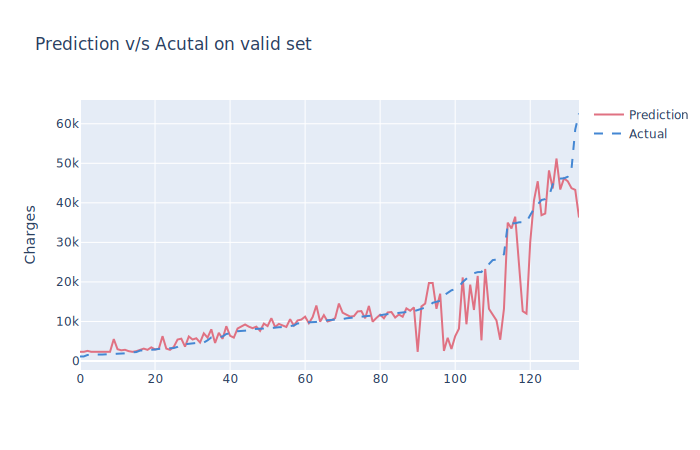

In [15]:
cols = [f'{target}_predict', target]

plot_data = (
    data
    .query('partition == "valid"')
    [cols]
    .sort_values(by=target)
    .reset_index(drop=True)
)

lines = [
    dict(column=f'{target}_predict', color=red, label="Prediction"), 
    dict(column=target, color=blue, label="Actual", dash='dash')
]

plot_lines(plot_data, lines, yaxis_title="Charges", title="Prediction v/s Acutal on valid set")

# BNN model

In [16]:
pyro.set_rng_seed(1312)

## Prior definition

In [17]:
net = deepcopy(regressor.network)
bayes_net = as_pyro_module(net, scale=1, tabnet_centered=True)
values = regressor.network.state_dict()

## Model definition

In [18]:
batch_size = 128

device = regressor.device
one = torch.ones(1).to(device)
zero = torch.ones(1).to(device)

#original
def model(x, y=None):
    
    #define priors
    preds = bayes_net(x)[0]
    sigma = 0.5*one
    
    #likelihood:
    if y is not None:
        with pyro.plate('observe_data', size=len(y), subsample_size=batch_size, device=device) as ind:
            pyro.sample('obs', dist.Normal(preds.index_select(0, ind), sigma).to_event(1), 
                        obs=y.index_select(0, ind))
    
    return preds

## Model training

In [19]:
init_scale=0.1
guide = AutoDiagonalNormal(
    model, 
    init_loc_fn=init_to_value(values=values), 
    init_scale=init_scale
)
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

### We check how inital model is doing

In [20]:
preds = get_predictions_pyro(    
    model, 
    guide,
    preprocessor,
    features,
    data, 
    n_samples=1000, 
    varbls=['_RETURN'],
    device=device,
)['_RETURN']

coverage_curves = get_empiric_coverage_curve(
    preds,
    data,
    target,
    inv_transf,
    coverages=np.linspace(.001, .999, 50)
)

metrics = get_metrics(
    model, 
    guide, 
    data, 
    features, 
    target, 
    preprocessor, 
    inv_transf, 
    n_samples=1000,
    device=device,
)

round(metrics, 2)

,MAPE,MAE,emp_coverage_80pct,perc_lenght_80pct,abs_lenght_80pct,confidence_error
partition,,,,,,
test,0.29,2899.92,0.93,1.73,15565.92,0.45
train,0.25,2365.01,0.93,1.64,15380.45,0.50
valid,0.28,3253.45,0.86,1.66,15604.27,0.43


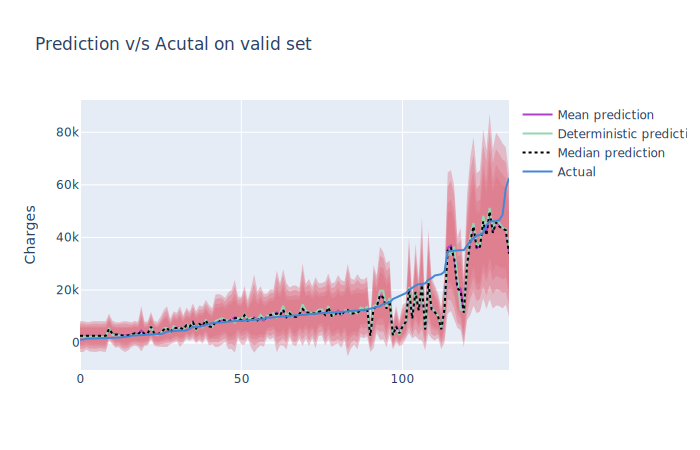

In [21]:
coverages = [.95, .9, .8, .7]
lower, upper = compute_confidence_intervals(preds, inv_transf, coverages=coverages)

for i, c in enumerate(coverages):
    data[f'lower_{int(100*c)}'] = lower[i, :]
    data[f'upper_{int(100*c)}'] = upper[i, :]

data['mean_prediction'] = inv_transf(preds).mean(axis=0).squeeze()
data['median_prediction'] = np.quantile(inv_transf(preds), 0.5, axis=0).squeeze()

areas = [
    dict(
        lower_column=f'lower_{int(100*c)}', 
        upper_column=f'upper_{int(100*c)}', 
        color="rgba(224, 113, 130, 0.4)",
        showlegend=False
    )
    for c in coverages
]

plot_data = (
    data
    .query('partition == "valid"')
    .sort_values(by=target)
    .reset_index(drop=True)
)

fig_areas = plot_areas(plot_data, areas)

lines = [
    dict(column='mean_prediction', color=purple, label="Mean prediction"), 
    dict(column=f'{target}_predict', color=green, label="Deterministic prediction"),
    dict(column='median_prediction', color='black', label="Median prediction", dash='dot'), 
    dict(column=target, color=blue, label="Actual",)
]

fig_lines = plot_lines(plot_data, lines)
fig = go.Figure(list(fig_areas.data) + list(fig_lines.data))
add_title_and_axis(fig, yaxis_title="Charges", title="Prediction v/s Acutal on valid set")
fig

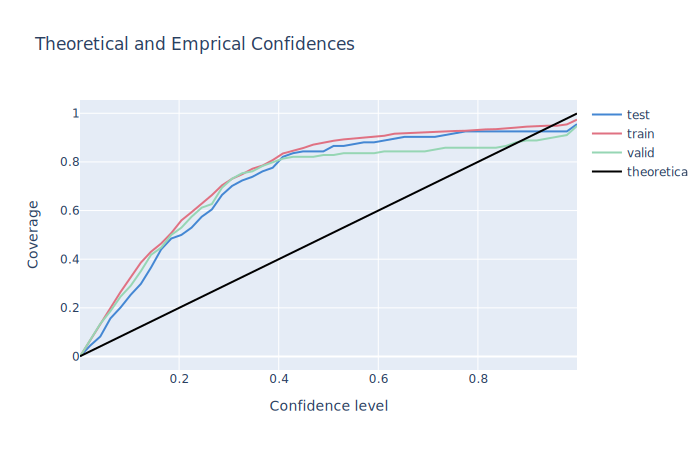

In [22]:
fig = plot_coverage_curves(coverage_curves)
fig.show()

In [23]:
compute_metrics = False

In [24]:
%%time
X_train_torch = torch.Tensor(X_train).to(device)
y_train_torch = torch.Tensor(y_train).to(device)

pyro.clear_param_store()
num_iterations = 600
metrics_list = []

for i in tqdm(range(num_iterations), total=num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train_torch, y_train_torch)
    if compute_metrics:
        metrics = get_metrics(
            model, 
            guide, 
            data, 
            features, 
            target, 
            preprocessor, 
            inv_transf, 
            n_samples=100,
            device=device,
        )   

        metrics.loc['train', 'elbo'] = loss
        metrics = (
            metrics
            .unstack()
            .dropna()
            .to_frame('value')
            .reset_index()
            .rename(columns={'level_0': 'metric'})
        )
        metrics['iteration'] = i
        metrics_list.append(metrics)
        results = pd.concat(metrics_list)

if compute_metrics:
    results.to_csv(f'results/{results_file}.csv')

  0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 43.4 s, sys: 129 ms, total: 43.5 s
Wall time: 43.3 s


In [25]:
results = pd.read_csv(f'results/{results_file}.csv')

## Training assesment

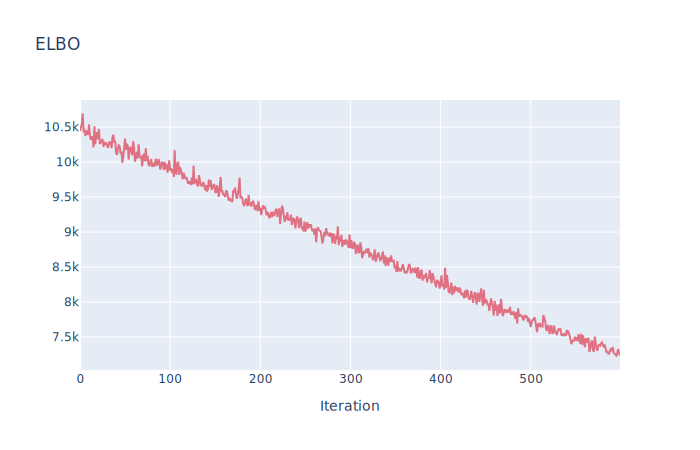

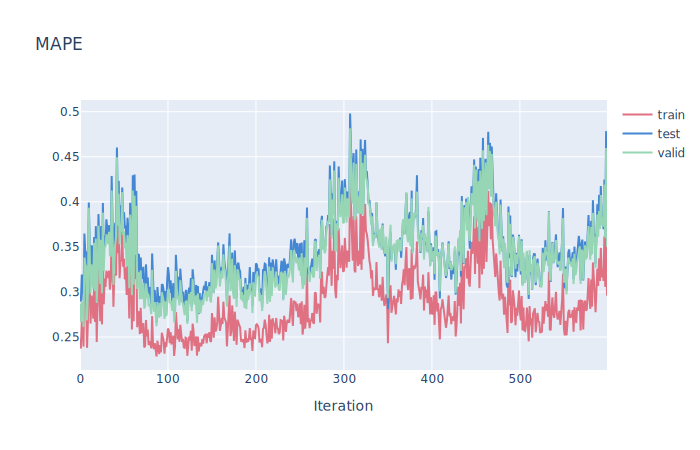

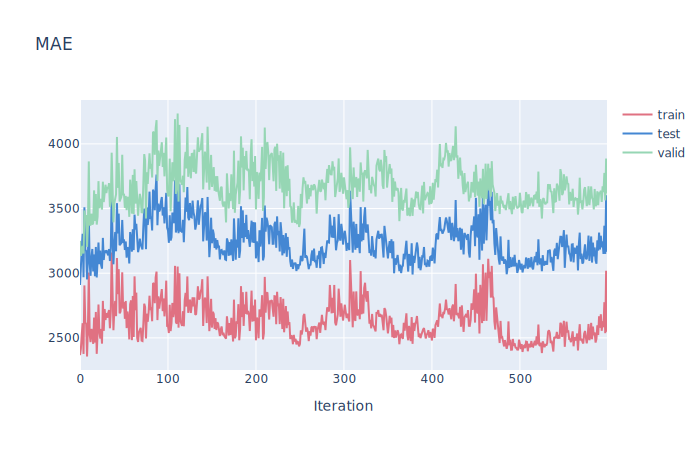

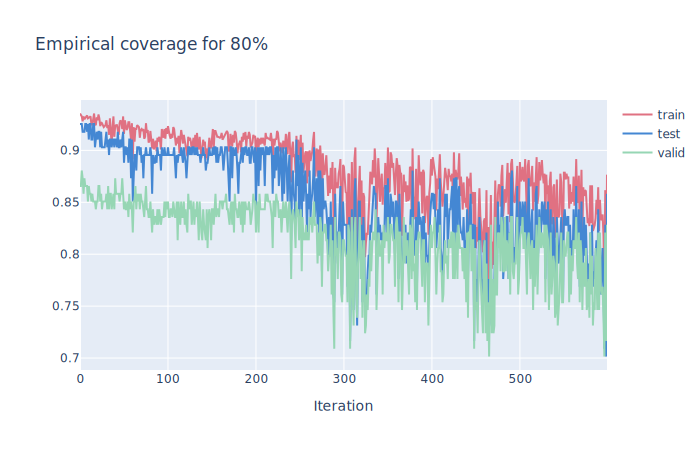

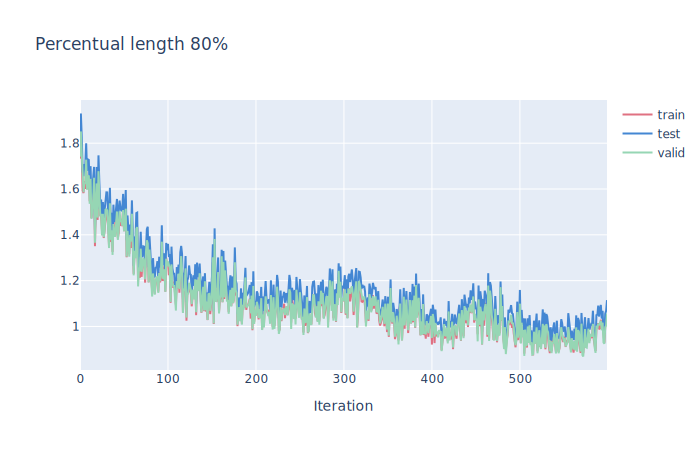

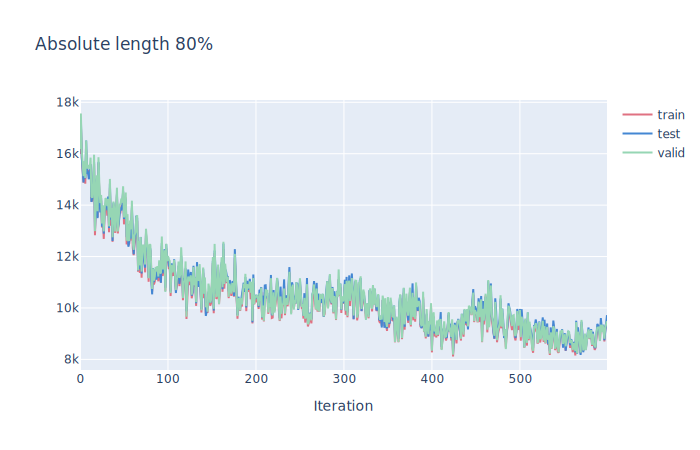

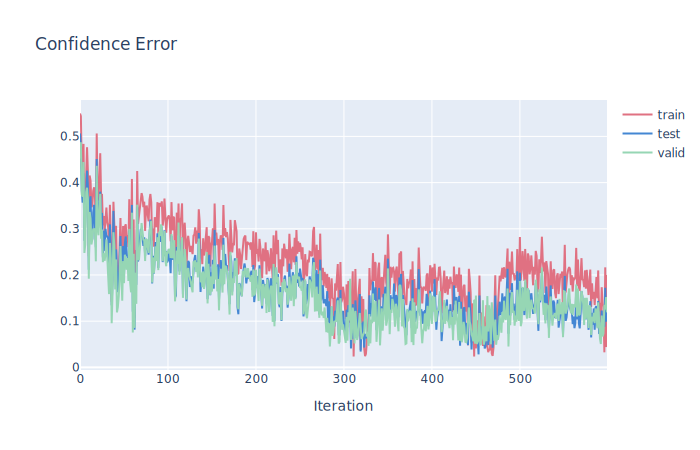

In [26]:
fig_list = plot_metrics(results)
for fig in fig_list: fig.show()

## Model assesment

### Coverage curves

In [27]:
preds = get_predictions_pyro(    
    model, 
    guide,
    preprocessor,
    features,
    data, 
    n_samples=1000, 
    varbls=['_RETURN'],
    device=device,
)['_RETURN']

coverage_curves = get_empiric_coverage_curve(
    preds,
    data,
    target,
    inv_transf,
    coverages=np.linspace(.001, .999, 50)
)

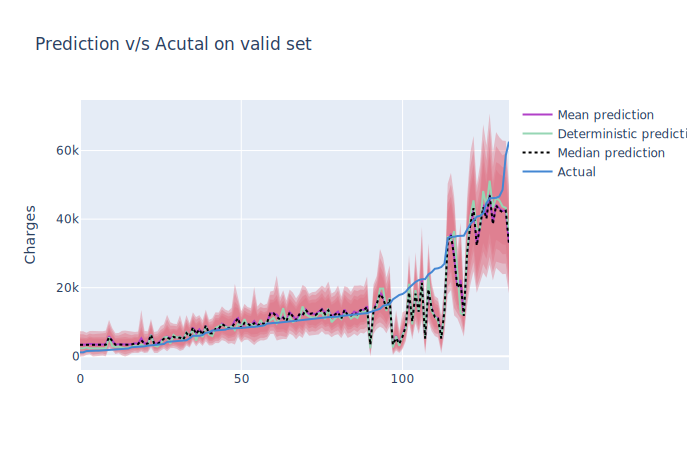

In [28]:
coverages = [.95, .9, .8, .7]
lower, upper = compute_confidence_intervals(preds, inv_transf, coverages=coverages)

for i, c in enumerate(coverages):
    data[f'lower_{int(100*c)}'] = lower[i, :]
    data[f'upper_{int(100*c)}'] = upper[i, :]

data['mean_prediction'] = inv_transf(preds).mean(axis=0).squeeze()
data['median_prediction'] = np.quantile(inv_transf(preds), 0.5, axis=0).squeeze()

areas = [
    dict(
        lower_column=f'lower_{int(100*c)}', 
        upper_column=f'upper_{int(100*c)}', 
        color="rgba(224, 113, 130, 0.4)",
        showlegend=False
    )
    for c in coverages
]

plot_data = (
    data
    .query('partition == "valid"')
    .sort_values(by=target)
    .reset_index(drop=True)
)

fig_areas = plot_areas(plot_data, areas)

lines = [
    dict(column='mean_prediction', color=purple, label="Mean prediction"), 
    dict(column=f'{target}_predict', color=green, label="Deterministic prediction"),
    dict(column='median_prediction', color='black', label="Median prediction", dash='dot'), 
    dict(column=target, color=blue, label="Actual",)
]

fig_lines = plot_lines(plot_data, lines)
fig = go.Figure(list(fig_areas.data) + list(fig_lines.data))
add_title_and_axis(fig, yaxis_title="Charges", title="Prediction v/s Acutal on valid set")
fig

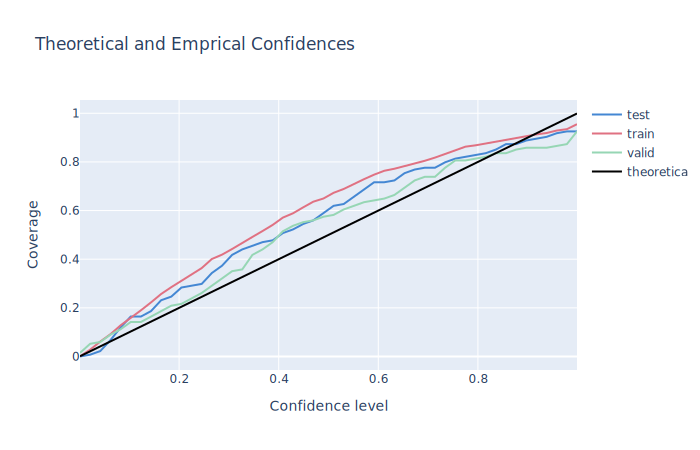

In [29]:
fig = plot_coverage_curves(coverage_curves)
fig.show()

## Other metrics

In [30]:
metrics = get_metrics(
    model, 
    guide, 
    data, 
    features, 
    target, 
    preprocessor, 
    inv_transf, 
    n_samples=1000,
    device=device,
)

round(metrics, 2)

,MAPE,MAE,emp_coverage_80pct,perc_lenght_80pct,abs_lenght_80pct,confidence_error
partition,,,,,,
test,0.36,3123.15,0.83,1.04,9468.14,0.14
train,0.29,2484.34,0.87,0.98,9317.27,0.20
valid,0.35,3572.88,0.81,1.00,9512.68,0.10


In [31]:
round(model_metrics, 2)

,MAPE,MedianAPE,MAE,MedianAE
partition,,,,
test,0.26,0.15,2934.92,1175.20
train,0.23,0.13,2378.41,1103.72
valid,0.25,0.12,3276.16,1079.88
